In [1]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.lw.info

import rtmtools.rrtmg.lw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse



importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.lw.info)

importlib.reload(rrtmgwrangle)
importlib.reload(rrtmganalyse)

<module 'rtmtools.rrtmg.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/rrtmg/sw/analyse.py'>

In [2]:
name_molecule = r'$O_{3}$'

#### Load CRD results

In [3]:
# Get lbl line-by-line results
pathout_crd = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H2008_O3_cut25/OUTPUT_RADSUM'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, cooling_rate = True, signed_fluxes = True)


In [13]:
# H1996 cutoff = 10 cm-1
pathout_crd1 = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H1996_H2O_cut10/OUTPUT_RADSUM'
pnl_crd1 = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd1, cooling_rate = True, signed_fluxes = True)


#### Load CLIRAD results

In [21]:
# Read OUTPUT_CLIRAD.dat
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_O3_H2012/OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad, cooling_rate = True, signed_fluxes= True)


In [5]:
# prepare results Hitran 2012 updated version
def path_cliradlw_h2012():
    return '../clirad/LW/examples/mls75_O3_H2012/CLIRAD_IR_output.dat'


def get_rateT(df, ratename = 'cooling rates'):
    return pd.DataFrame({'pressure': .5 * (df['p'].values[1:] + df['p'].values[: -1]),
                    ratename: df[ratename].values[1:]})


df = cliradwrangle.output_txtfile_to_DataFrame(path_cliradlw_h2012())

rateT_clirad2012 = get_rateT(df, ratename = 'cooling rates')

#### Load LBLRTM results

In [6]:
# Get AER line-by-line results
pathout_lblrtm = '/nuwa_cluster/home/jackyu/line_by_line/aerlbl_v12.2_package/runs/LW/run_mls75pro_O3/OUTPUT_RADSUM'
pnl_lblrtm = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_lblrtm, signed_fluxes = True, cooling_rate = True)


#### Load RRTMG results

In [7]:
pathout_rrtmg = '/nuwa_cluster/home/jackyu/radiation/rrtmg/LW/examples/mls70_O3/OUTPUT_RRTM'
pnl_rrtmg = rrtmgwrangle.OUTPUT_RRTM_to_pandasPanel(readfrom = pathout_rrtmg, signed_fluxes = True, cooling_rate = True)


# Total cooling rates

In [8]:
def plot_total_cooling_rates(infos_wavenumber = None, infos_spectralband = None):
    global molecule_name
    
    names_wavenumber, colours_wavenumber, linestyles_wavenumber, pnls_wavenumber = \
    map(list, zip(*infos_wavenumber))
    
    dfs_wavenumber = [aeranalyse.sum_OUTPUT_RADSUM_over_wbands(pnl, V1 = 0, V2 = 3000) \
                      for pnl in pnls_wavenumber]
    
    names_spectralband, colours_spectralband, linestyles_spectralband, pnls_spectralband = \
    map(list, zip(*infos_spectralband))
    
    dfs_spectralband = [cliradanalyse.sum_OUTPUT_CLIRAD_over_wbands(pnl, wbands = range(1, 11))\
                       for pnl in pnls_spectralband]
    
    viz.plot_pres_vs_hrcr(dfs = dfs_wavenumber + dfs_spectralband,
                          names = names_wavenumber + names_spectralband,
                          linestyles = linestyles_wavenumber + linestyles_spectralband, 
                          colours = colours_wavenumber + colours_spectralband,
                          title = 'Total cooling rate. {}'.format(name_molecule),
                              cooling_rate = True)
    
    display.display(plt.gcf()); plt.close()
    

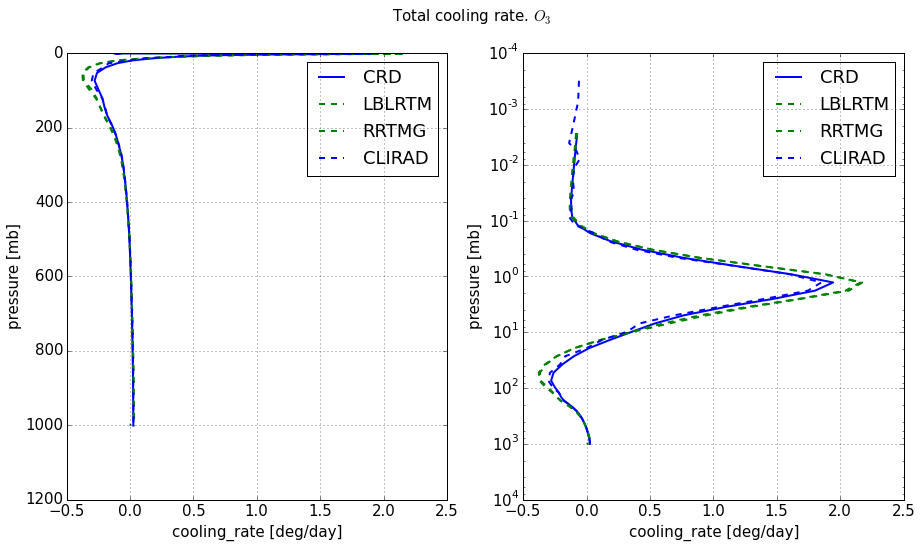

In [22]:
plot_total_cooling_rates(infos_wavenumber = [('CRD', 'b', '-', pnl_crd),\
                                            ('LBLRTM', 'g', '--', pnl_lblrtm),\
                                            ('RRTMG', 'g', '--', pnl_rrtmg)],
                        infos_spectralband = [('CLIRAD', 'b', '--', pnl_clirad)])

# In RRTMG's wavenumber bands

In [10]:

def fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, *infos_lbl):
    global name_molecule
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
        
    names.append('RRTMG')
    colours.append('g')
    linestyles.append('--')
    
    lbl_pnls_by_rrtmg_bands = [aeranalyse.lines2bands(pnl_lbl, wbands = pnl_rrtmg.items.values)\
                              for pnl_lbl in pnls_lbl]
    
    for item in pnl_rrtmg.items:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[item].loc[atm_levels, :] for pnl in lbl_pnls_by_rrtmg_bands]
        dfs.append(pnl_rrtmg[item].loc[atm_levels, :])
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'RRTMG Wavenumber band: {} ~ {} cm-1'.format(*item))      
        dfs = [pnl[item] for pnl in lbl_pnls_by_rrtmg_bands]
        dfs.append(pnl_rrtmg[item])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Cooling rate {} {} ~ {} cm-1'.format(name_molecule, *item),
                              cooling_rate = True)
    
        display.display(plt.gcf()); plt.close()
    


Flux tables and cooling rates in RRTMG spectral bands


---------------------------------------------------------------------------


RRTMG Wavenumber band: 10.0 ~ 350.0 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -54.573788  0.000000e+00 -54.573788  0.000000e+00
30   299.800000 -54.573788  2.819921e-07 -54.573787  1.311528e-09
0   1013.000000 -54.573788  5.670697e-07 -54.573787  3.837701e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -54.630229   0.000000 -54.630229      0.000000
30   299.8000 -54.660391   0.080099 -54.580292      0.000198
0   1013.0000 -54.581667   0.095058 -54.486609      0.028816

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -54.5825          0  -54.5825            -0
30   299.70000 -54.5825          0  -54.5825            -0
0   1013.00000 -54.5825          0  -54.5825            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  co

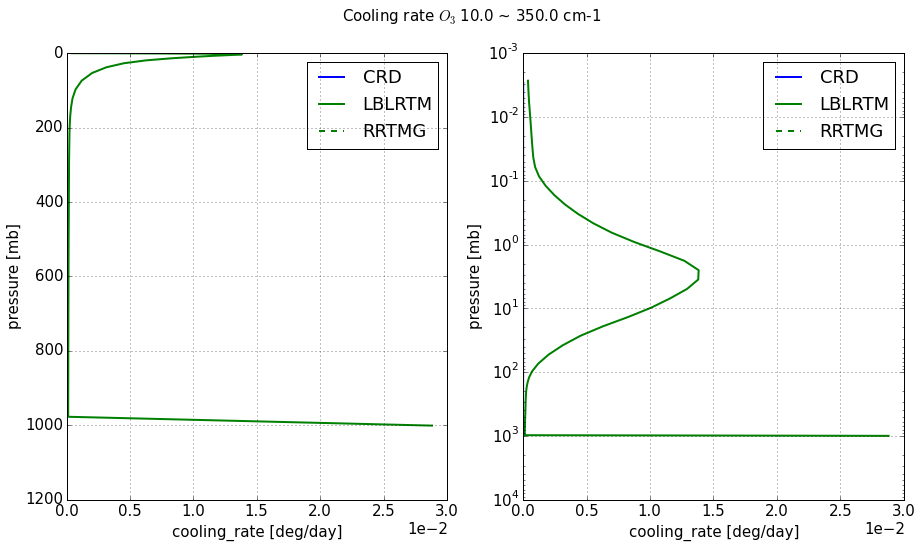

---------------------------------------------------------------------------


RRTMG Wavenumber band: 350.0 ~ 500.0 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -60.916637  0.000000e+00 -60.916637  0.000000e+00
30   299.800000 -60.916638  2.644419e-07 -60.916637  5.833640e-10
0   1013.000000 -60.916638  5.671926e-07 -60.916637  4.275775e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -60.928586   0.000000 -60.928586  0.000000e+00
30   299.8000 -60.928885   0.000391 -60.928495  5.338283e-07
0   1013.0000 -60.917465   0.000504 -60.916961  4.063699e-03

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -60.9174          0  -60.9174            -0
30   299.70000 -60.9174          0  -60.9174            -0
0   1013.00000 -60.9174          0  -60.9174            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017  0.011948   0.000000  0.011948 

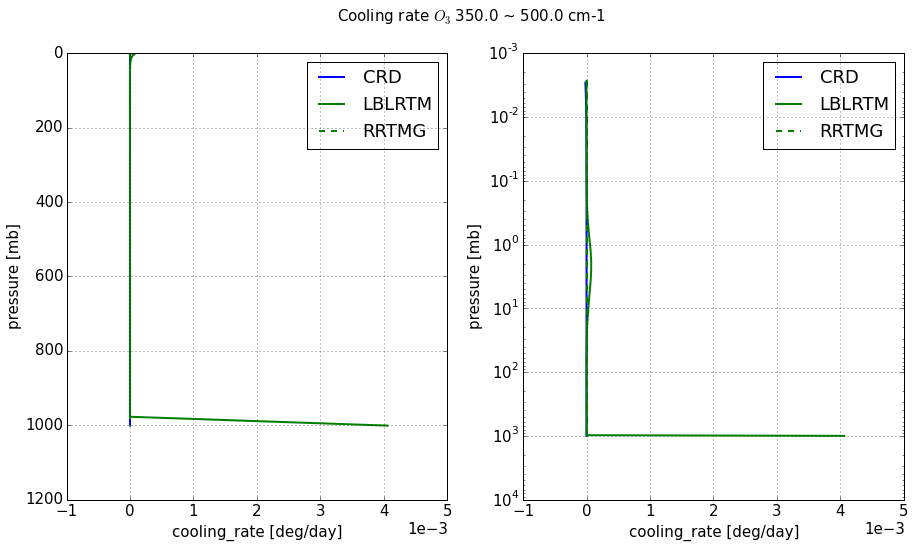

---------------------------------------------------------------------------


RRTMG Wavenumber band: 500.0 ~ 630.0 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -58.652387  0.000000e+00 -58.652387  0.000000e+00
30   299.800000 -58.652387  2.203418e-07 -58.652386 -5.988993e-11
0   1013.000000 -58.652387  5.000336e-07 -58.652386  4.110279e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -58.607044   0.000000 -58.607044      0.000000
30   299.8000 -58.634682   0.019092 -58.615591     -0.000013
0   1013.0000 -58.646623   0.024863 -58.621760     -0.003475

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -58.6466          0  -58.6466            -0
30   299.70000 -58.6466          0  -58.6466            -0
0   1013.00000 -58.6466          0  -58.6466            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.045343   0.000000 -0.045343 

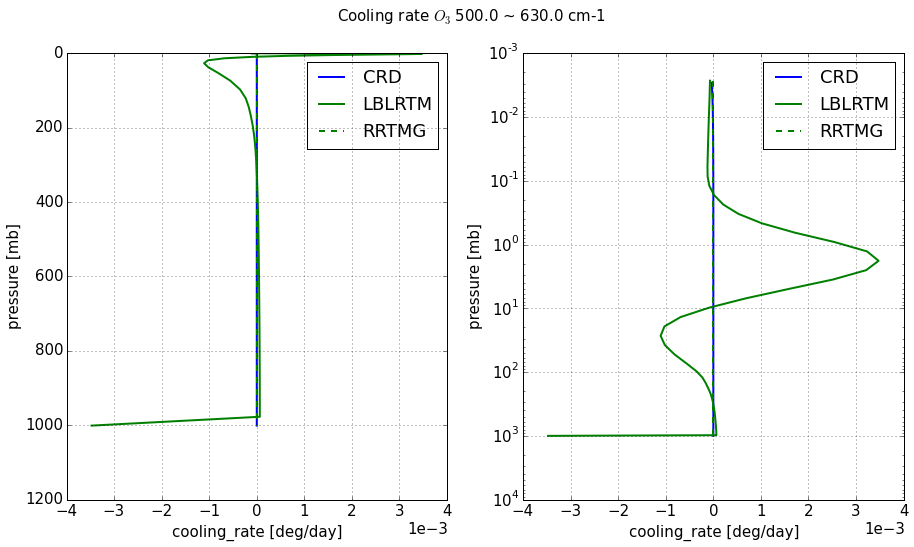

---------------------------------------------------------------------------


RRTMG Wavenumber band: 630.0 ~ 700.0 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -30.901144  0.000000e+00 -30.901144  0.000000e+00
30   299.800000 -30.901144  1.041794e-07 -30.901144 -2.530970e-10
0   1013.000000 -30.901144  2.470559e-07 -30.901144  2.162866e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -29.977814   0.000000 -29.977814      0.000000
30   299.8000 -30.832188   0.488407 -30.343781     -0.000893
0   1013.0000 -30.895458   0.605721 -30.289736     -0.002771

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -30.3159     0.0000  -30.3159            -0
30   299.70000 -30.8956     0.3455  -30.5501            -0
0   1013.00000 -30.8956     0.3455  -30.5501            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.923329   0.000000 -0.923329 

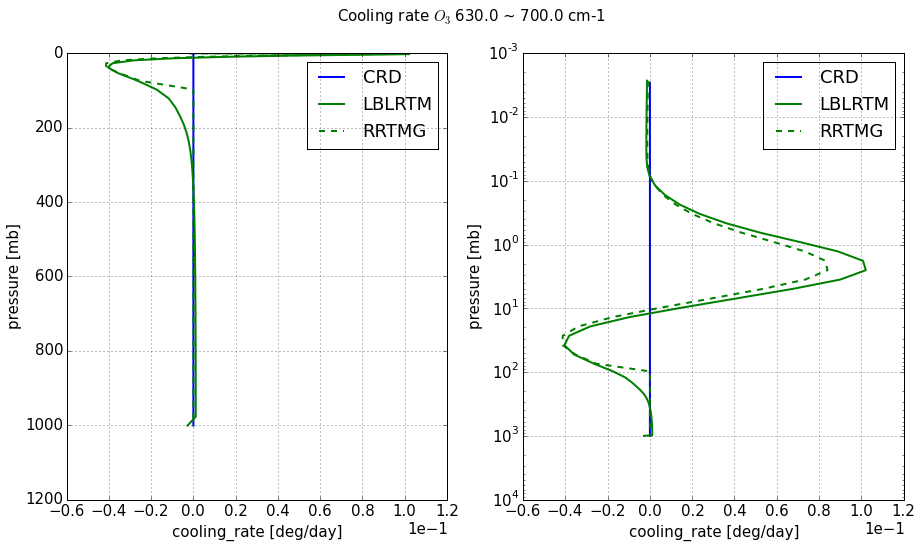

---------------------------------------------------------------------------


RRTMG Wavenumber band: 700.0 ~ 820.0 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -48.899846  0.000000e+00 -48.899846  0.000000e+00
30   299.800000 -48.899846  1.488874e-07 -48.899845 -7.042967e-10
0   1013.000000 -48.899846  3.684535e-07 -48.899845  3.418567e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -47.703364   0.000000 -47.703364      0.000000
30   299.8000 -48.795771   0.549176 -48.246595     -0.001471
0   1013.0000 -48.886744   0.695462 -48.191282     -0.005819

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -47.6750     0.0000  -47.6750      -0.00000
30   299.70000 -48.8203     0.5217  -48.2986      -0.00133
0   1013.00000 -48.8871     0.6604  -48.2267       0.00135

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -1.196481   0.000000 -1.196481 

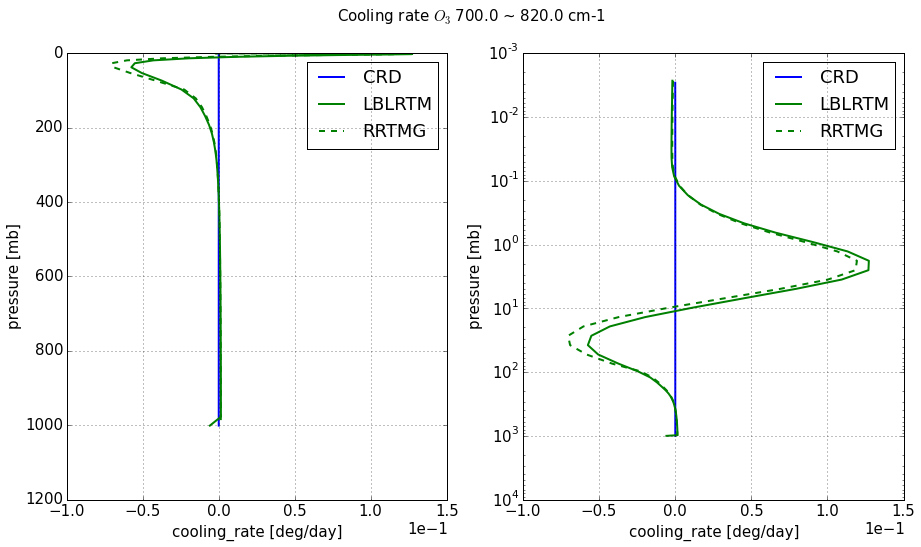

---------------------------------------------------------------------------


RRTMG Wavenumber band: 820.0 ~ 980.0 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -53.981633  0.000000e+00 -53.981633  0.000000e+00
30   299.800000 -53.981634  1.416120e-07 -53.981634 -1.219487e-09
0   1013.000000 -53.981634  3.738202e-07 -53.981634  3.767053e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -53.906150   0.000000 -53.906150      0.000000
30   299.8000 -53.933699   0.011429 -53.922270     -0.000057
0   1013.0000 -53.960338   0.020409 -53.939929     -0.007977

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -53.9607          0  -53.9607            -0
30   299.70000 -53.9607          0  -53.9607            -0
0   1013.00000 -53.9607          0  -53.9607            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.075484   0.000000 -0.075484 

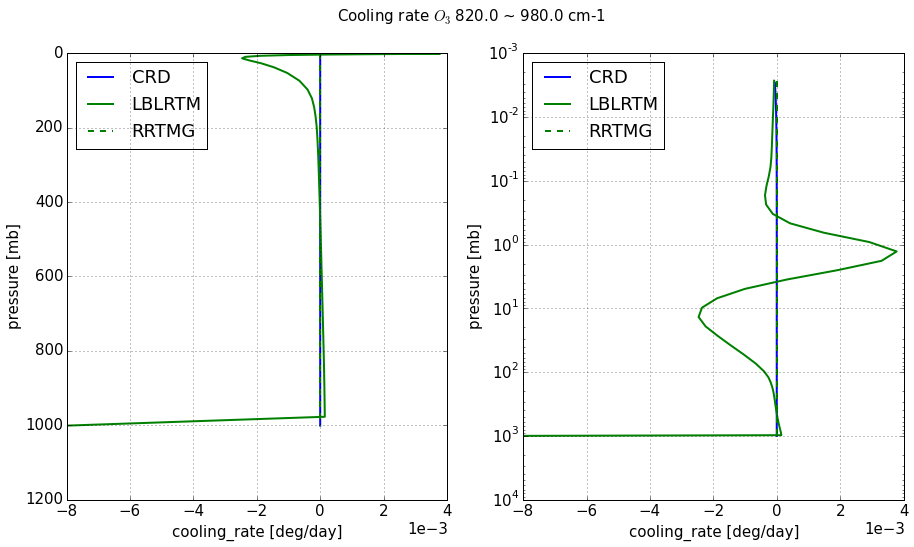

---------------------------------------------------------------------------


RRTMG Wavenumber band: 980.0 ~ 1080.0 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -18.542117   0.000000 -18.542117      0.000000
30   299.800000 -24.723457   2.022201 -22.701256     -0.059611
0   1013.000000 -26.654056   4.321516 -22.332540      0.026223

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -18.354242   0.000000 -18.354242      0.000000
30   299.8000 -24.720024   2.035311 -22.684713     -0.061416
0   1013.0000 -26.640246   4.302499 -22.337746      0.022199

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -18.3205     0.0000  -18.3205      -0.00000
30   299.70000 -24.6755     2.0180  -22.6575      -0.06534
0   1013.00000 -26.6401     4.4076  -22.2325       0.02820

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.187874   0.000000 -0.187874      0.0000

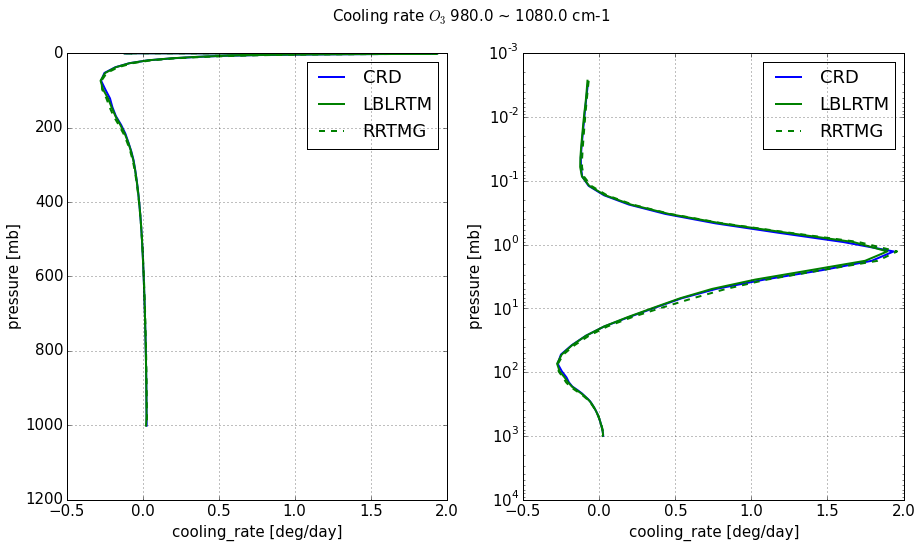

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1080.0 ~ 1180.0 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -21.369760   0.000000 -21.369760      0.000000
30   299.800000 -21.525225   0.041361 -21.483864     -0.000346
0   1013.000000 -21.535940   0.056672 -21.479268      0.000176

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -20.917206   0.000000 -20.917206      0.000000
30   299.8000 -21.474850   0.137019 -21.337830     -0.001305
0   1013.0000 -21.522739   0.191802 -21.330937     -0.002425

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -20.9504     0.0000  -20.9504      -0.00000
30   299.70000 -21.4862     0.1338  -21.3524      -0.00119
0   1013.00000 -21.5225     0.1850  -21.3375       0.00059

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.452554   0.000000 -0.452554      0.000

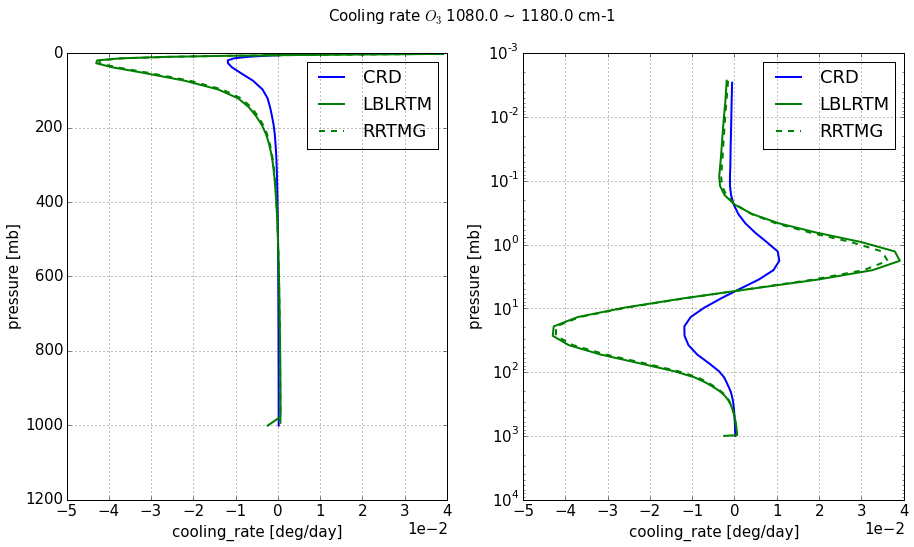

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1180.0 ~ 1390.0 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -31.323236  0.000000e+00 -31.323236  0.000000e+00
30   299.800000 -31.323236  5.537980e-08 -31.323236 -1.247450e-09
0   1013.000000 -31.323236  1.756035e-07 -31.323236  2.174742e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -31.267505   0.000000 -31.267505      0.000000
30   299.8000 -31.285929   0.004517 -31.281412     -0.000042
0   1013.0000 -31.299603   0.006876 -31.292726     -0.004272

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -31.2994          0  -31.2994            -0
30   299.70000 -31.2994          0  -31.2994            -0
0   1013.00000 -31.2994          0  -31.2994            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.055731   0.000000 -0.05573

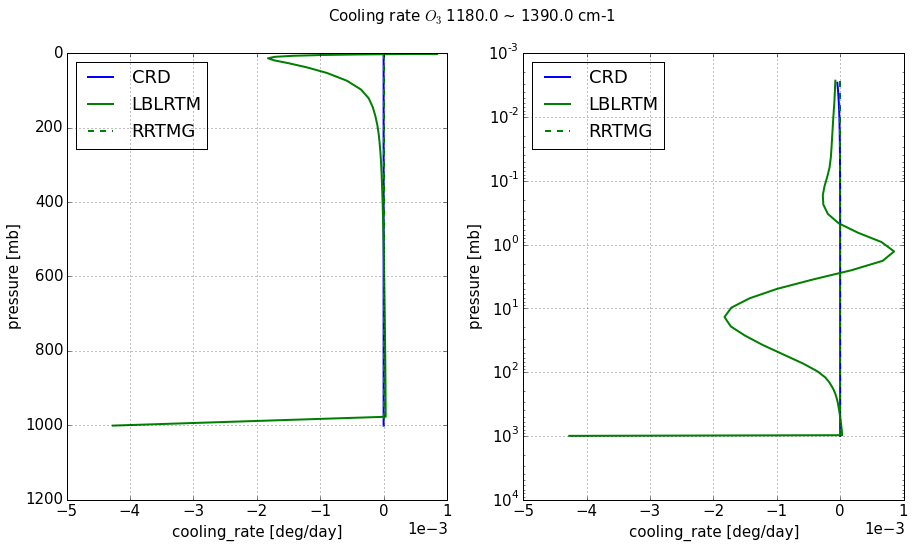

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1390.0 ~ 1480.0 cm-1

CRD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -8.906562  0.000000e+00 -8.906562  0.000000e+00
30   299.800000 -8.906562  1.346605e-08 -8.906562 -4.019412e-10
0   1013.000000 -8.906562  4.614281e-08 -8.906562  6.170478e-10

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -8.893864   0.000000 -8.893864      0.000000
30   299.8000 -8.894650   0.000135 -8.894514     -0.000002
0   1013.0000 -8.898490   0.000210 -8.898279     -0.001340

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -8.8986          0   -8.8986            -0
30   299.70000  -8.8986          0   -8.8986            -0
0   1013.00000  -8.8986          0   -8.8986            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.012698   0.000000 -0.012698      0.000000


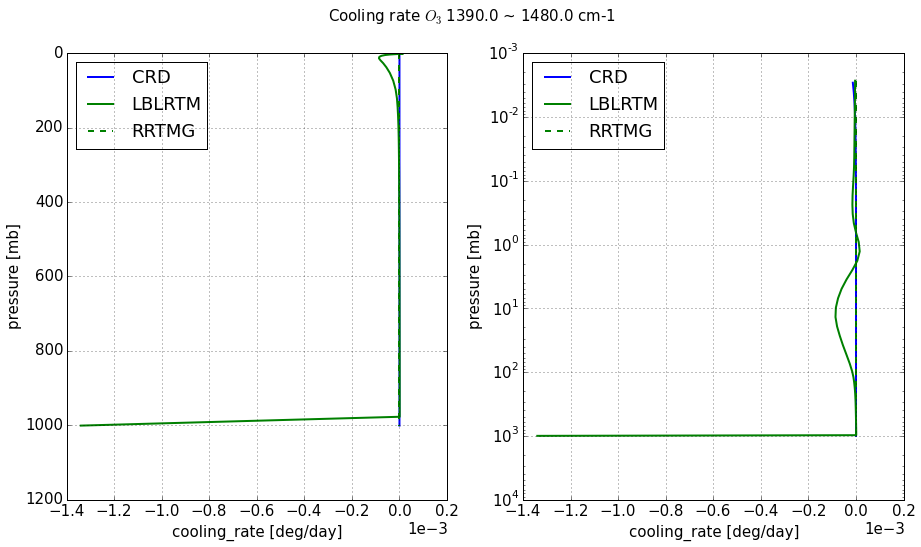

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1480.0 ~ 1800.0 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -17.902258  0.000000e+00 -17.902258  0.000000e+00
30   299.800000 -17.902258  2.291789e-08 -17.902258 -8.945306e-10
0   1013.000000 -17.902258  8.544518e-08 -17.902258  1.237200e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -17.838741   0.000000 -17.838741      0.000000
30   299.8000 -17.871812   0.003319 -17.868492     -0.000087
0   1013.0000 -17.882889   0.005211 -17.877677     -0.003128

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -17.8828          0  -17.8828            -0
30   299.70000 -17.8828          0  -17.8828            -0
0   1013.00000 -17.8828          0  -17.8828            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.063517   0.000000 -0.06351

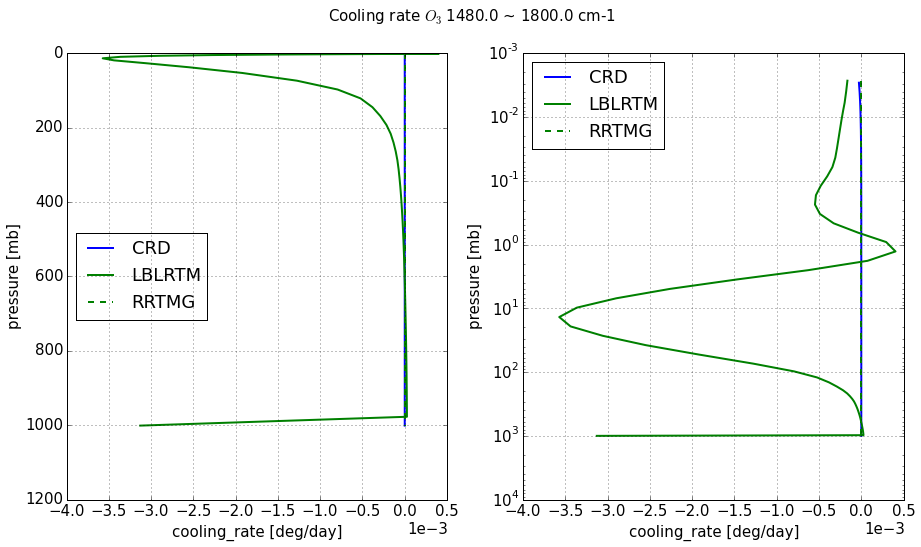

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1800.0 ~ 2080.0 cm-1

CRD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -5.965987  0.000000e+00 -5.965987  0.000000e+00
30   299.800000 -5.965987  5.834966e-09 -5.965987 -3.356538e-10
0   1013.000000 -5.965987  2.509201e-08 -5.965987  4.105883e-10

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -5.865690   0.000000 -5.865690      0.000000
30   299.8000 -5.893006   0.001965 -5.891040     -0.000087
0   1013.0000 -5.957771   0.003947 -5.953824     -0.022073

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -5.9578          0   -5.9578            -0
30   299.70000  -5.9578          0   -5.9578            -0
0   1013.00000  -5.9578          0   -5.9578            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.100297   0.000000 -0.100297      0.000000


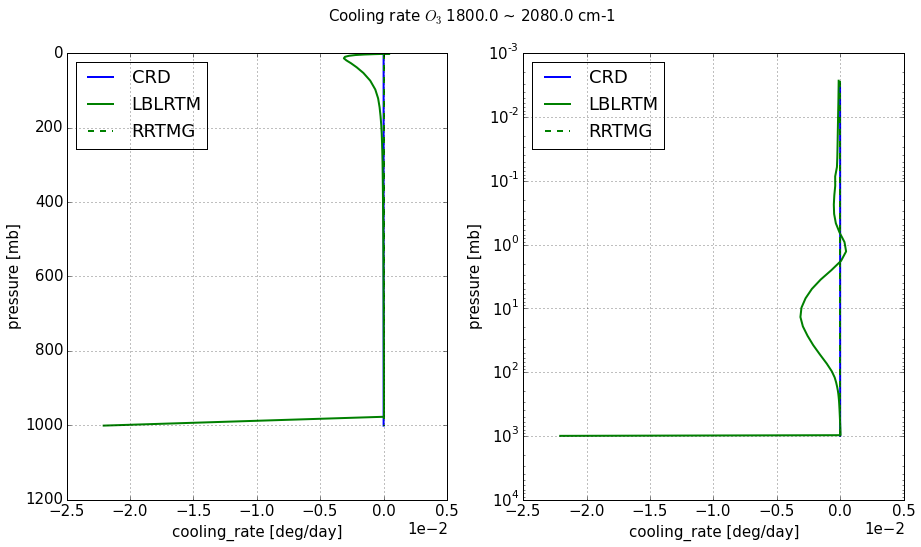

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2080.0 ~ 2250.0 cm-1

CRD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -1.641655  0.000000e+00 -1.641655  0.000000e+00
30   299.800000 -1.641655  1.318907e-09 -1.641655 -9.823153e-11
0   1013.000000 -1.641655  6.319246e-09 -1.641655  1.126136e-10

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -1.517403   0.000000 -1.517403      0.000000
30   299.8000 -1.625354   0.005199 -1.620155     -0.000516
0   1013.0000 -1.639014   0.013533 -1.625481     -0.000225

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -1.5417     0.0000   -1.5417            -0
30   299.70000  -1.6390     0.0075   -1.6315            -0
0   1013.00000  -1.6390     0.0076   -1.6314            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.124252   0.000000 -0.124252      0.000000


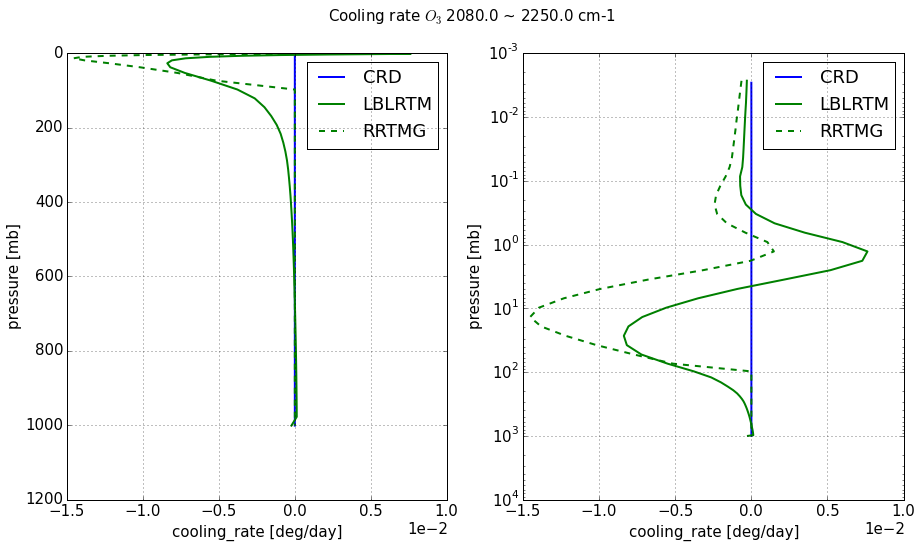

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2250.0 ~ 2380.0 cm-1

CRD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -0.732844  0.000000e+00 -0.732844  0.000000e+00
30   299.800000 -0.732844  5.224365e-10 -0.732844 -4.517531e-11
0   1013.000000 -0.732844  2.676597e-09 -0.732844  5.016600e-11

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.730956   0.000000 -0.730956  0.000000e+00
30   299.8000 -0.731077   0.000007 -0.731070 -3.775092e-07
0   1013.0000 -0.731556   0.000016 -0.731539 -1.655832e-04

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.7315          0   -0.7315            -0
30   299.70000  -0.7315          0   -0.7315            -0
0   1013.00000  -0.7316          0   -0.7316            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.001887   0.000000 -0.001887  0.000000e+00


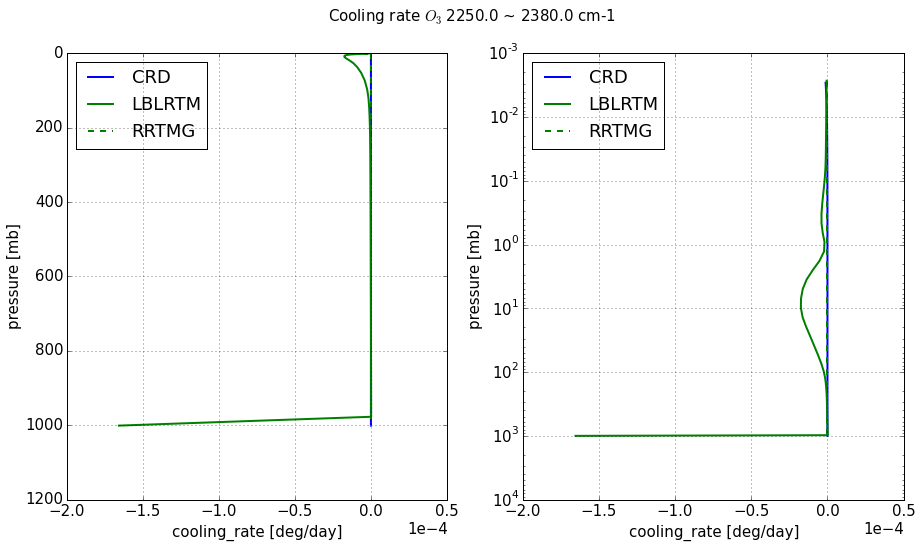

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2380.0 ~ 2600.0 cm-1

CRD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -0.667119  0.000000e+00 -0.667119  0.000000e+00
30   299.800000 -0.667119  4.207911e-10 -0.667119 -4.218625e-11
0   1013.000000 -0.667119  2.310911e-09 -0.667119  4.556381e-11

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.665366   0.000000 -0.665366  0.000000e+00
30   299.8000 -0.665406   0.000002 -0.665404 -1.121754e-07
0   1013.0000 -0.665840   0.000003 -0.665836 -1.530274e-04

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.5485     0.0000   -0.5485      -0.00000
30   299.70000  -0.5700     0.0007   -0.5693      -0.00110
0   1013.00000  -0.6658     0.1148   -0.5510       0.00315

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.001754   0.000000 -0.001754  0.000000e+00


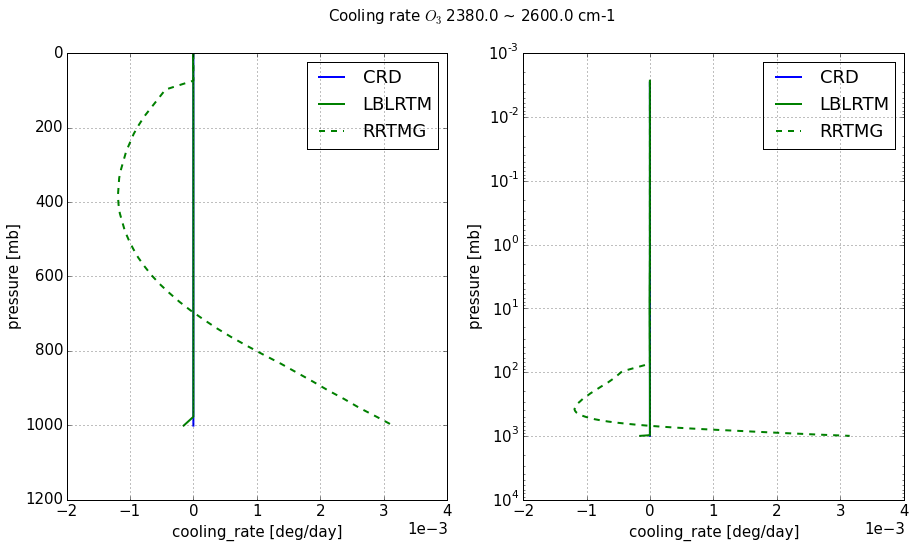

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2600.0 ~ 3250.0 cm-1

CRD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -0.404431  0.000000e+00 -0.404431  0.000000e+00
30   299.800000 -0.404431  2.104346e-10 -0.404431 -2.639985e-11
0   1013.000000 -0.404431  1.291457e-09 -0.404431  2.751858e-11

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.401927   0.000000 -0.401927      0.000000
30   299.8000 -0.402391   0.000013 -0.402378     -0.000001
0   1013.0000 -0.403547   0.000032 -0.403515     -0.000397

RRTMG
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.4713          0   -0.4713            -0
30   299.70000  -0.4713          0   -0.4713            -0
0   1013.00000  -0.4713          0   -0.4713            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.002504   0.000000 -0.002504      0.000000


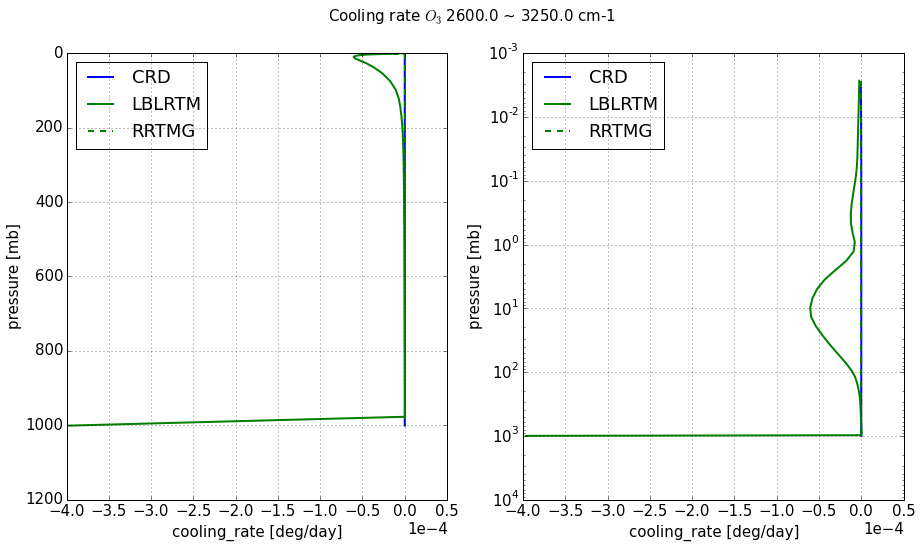

In [11]:
print('Flux tables and cooling rates in RRTMG spectral bands')
print()
print()

fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, \
                                ('CRD', 'b', '-', pnl_crd), \
                               ('LBLRTM', 'g', '-', pnl_lblrtm))   

# In CLIRAD's wavenumber bands

In [61]:
clirad_wbands = rtmtools.clirad.lw.info.wavenumber_bands()

In [75]:
levels = [70, 30, 0]
attrs = ['pressure', 'flux_up', 'flux_down', 'net_flux', 'cooling_rate']
name_molecule = '$H_2O$'
wbands = list(range(1, 10 + 1))
wranges = {wband: clirad_wbands[wband] for wband in wbands}

In [76]:
crd_wrt_clirad = rtmtools.clirad.sw.analyse.lines2bands(pnl_crd, wbands = wranges)
crd_wrt_clirad_lvls = crd_wrt_clirad.ix[:, levels, :]

In [94]:
lblrtm_wrt_clirad = rtmtools.clirad.sw.analyse.lines2bands(pnl_lblrtm, wbands = wranges)
lblrtm_wrt_clirad_lvls = lblrtm_wrt_clirad.ix[:, levels, :]

In [77]:
clirad_wrt_clirad = pnl_clirad.ix[:, :, attrs]
clirad_wrt_clirad_lvls = clirad_wrt_clirad.ix[:, levels, :]

In [12]:


def fluxtableNhrplot_by_clirad_bands(pnl_clirad, *infos_lbl):    
    global name_molecule
    clirad_wbands = rtmtools.clirad.lw.info.wavenumber_bands()
    wbands = list(range(1, 10 + 1))
    wranges = {wband: clirad_wbands[wband] for wband in wbands}
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
        
    names.append('CLIRAD')
    colours.append('b')
    linestyles.append('--')
    
    lbl_pnls_by_clirad_bands = [rtmtools.clirad.sw.analyse.lines2bands(pnl_lbl, wbands = wranges)\
                              for pnl_lbl in pnls_lbl]
    
    for wband in wbands:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[wband].loc[atm_levels, :] for pnl in lbl_pnls_by_clirad_bands]
        dfs.append(pnl_clirad[wband].loc[atm_levels, :])
        
        wlabel = ' '.join(['{} ~ {}'.format(*interval) for interval in wranges[wband]]) + ' cm-1'
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'Wavenumber band: {}, {}'.format(wband, wlabel))
        
        dfs = [pnl[wband] for pnl in lbl_pnls_by_clirad_bands]
        dfs.append(pnl_clirad[wband])
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Cooling rate {} {}'.format(name_molecule, wlabel),
                              cooling_rate = True)
    
        display.display(plt.gcf()); plt.close()    


Flux tables and cooling rates in CLIRAD spectral bands


---------------------------------------------------------------------------


Wavenumber band: 1, 0 ~ 340 cm-1

CRD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -51.09304  0.000000e+00 -51.093040  0.000000e+00
30   299.800000 -51.09304  2.655836e-07 -51.093040  1.255140e-09
0   1013.000000 -51.09304  5.329452e-07 -51.093039  3.593164e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -51.148164   0.000000 -51.148164      0.000000
30   299.8000 -51.178177   0.079914 -51.098263      0.000198
0   1013.0000 -51.100657   0.094825 -51.005832      0.028385

CLIRAD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -51.09215   0.000004 -51.092146            -0
30   299.800000 -51.09215   0.000004 -51.092146            -0
0   1013.000000 -51.09215   0.000004 -51.092146            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  

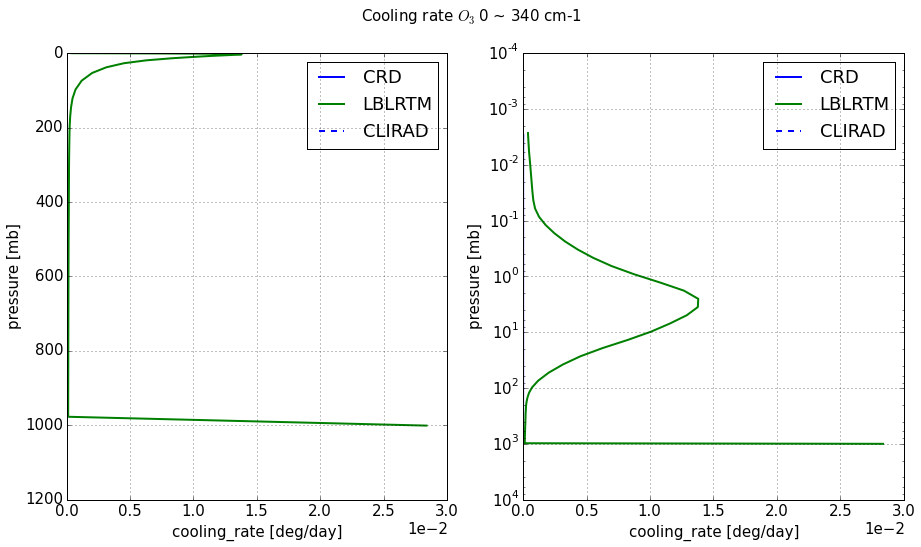

---------------------------------------------------------------------------


Wavenumber band: 2, 340 ~ 540 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -82.315834  0.000000e+00 -82.315834  0.000000e+00
30   299.800000 -82.315835  3.514494e-07 -82.315834  6.818576e-10
0   1013.000000 -82.315835  7.585482e-07 -82.315834  5.776692e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -82.326400   0.000000 -82.326400  0.000000e+00
30   299.8000 -82.326854   0.000592 -82.326262  8.123909e-07
0   1013.0000 -82.315849   0.000755 -82.315094  3.920285e-03

CLIRAD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -82.31578   0.000004 -82.315776            -0
30   299.800000 -82.31578   0.000008 -82.315772            -0
0   1013.000000 -82.31578   0.000008 -82.315772            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017  0.010566   0.000000  0.0

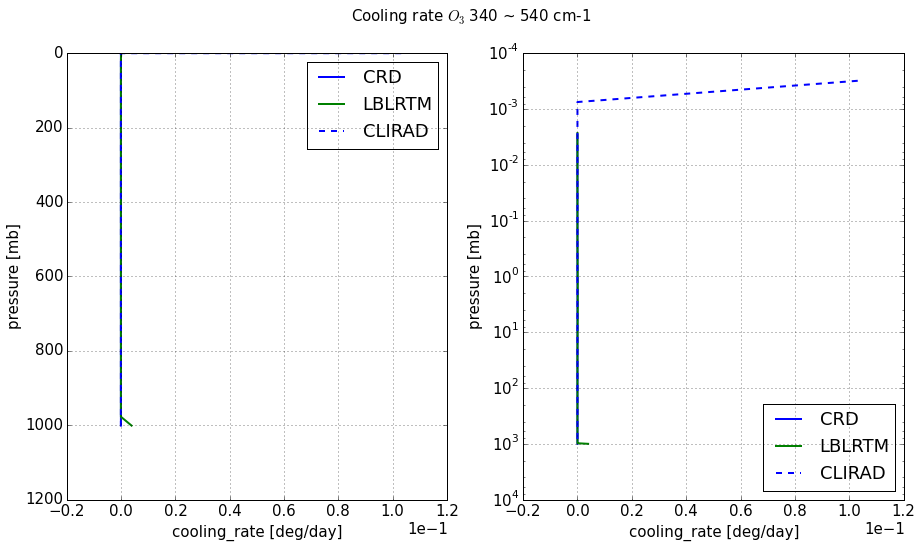

---------------------------------------------------------------------------


Wavenumber band: 3, 540 ~ 800 cm-1

CRD
       pressure     flux_up     flux_down    net_flux  cooling_rate
70     0.002417 -112.837813  0.000000e+00 -112.837813  0.000000e+00
30   299.800000 -112.837813  3.806693e-07 -112.837813 -9.236175e-10
0   1013.000000 -112.837813  9.021645e-07 -112.837812  7.897587e-09

LBLRTM
     pressure     flux_up  flux_down    net_flux  cooling_rate
70     0.0024 -110.692149   0.000000 -110.692149      0.000000
30   299.8000 -112.656351   1.051774 -111.604577     -0.002363
0   1013.0000 -112.816764   1.319290 -111.497473     -0.010324

CLIRAD
       pressure  flux_up  flux_down    net_flux  cooling_rate
70     0.002417 -112.816   0.000004 -112.815996            -0
30   299.800000 -112.816   0.000008 -112.815992            -0
0   1013.000000 -112.816   0.000008 -112.815992            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -2.145664

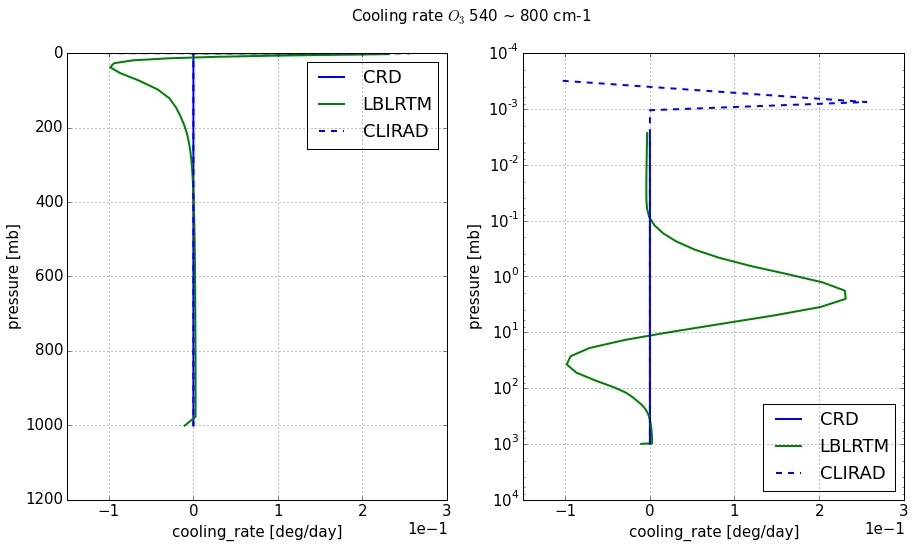

---------------------------------------------------------------------------


Wavenumber band: 4, 800 ~ 980 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -61.681242  0.000000e+00 -61.681242  0.000000e+00
30   299.800000 -61.681243  1.637677e-07 -61.681243 -1.355153e-09
0   1013.000000 -61.681243  4.299970e-07 -61.681242  4.304974e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -61.589145   0.000000 -61.589145      0.000000
30   299.8000 -61.626912   0.016330 -61.610582     -0.000070
0   1013.0000 -61.657526   0.027165 -61.630361     -0.009081

CLIRAD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -61.64932          0 -61.64932            -0
30   299.800000 -61.64932          0 -61.64932            -0
0   1013.000000 -61.64932          0 -61.64932            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.092097   0.000000 -0.09209

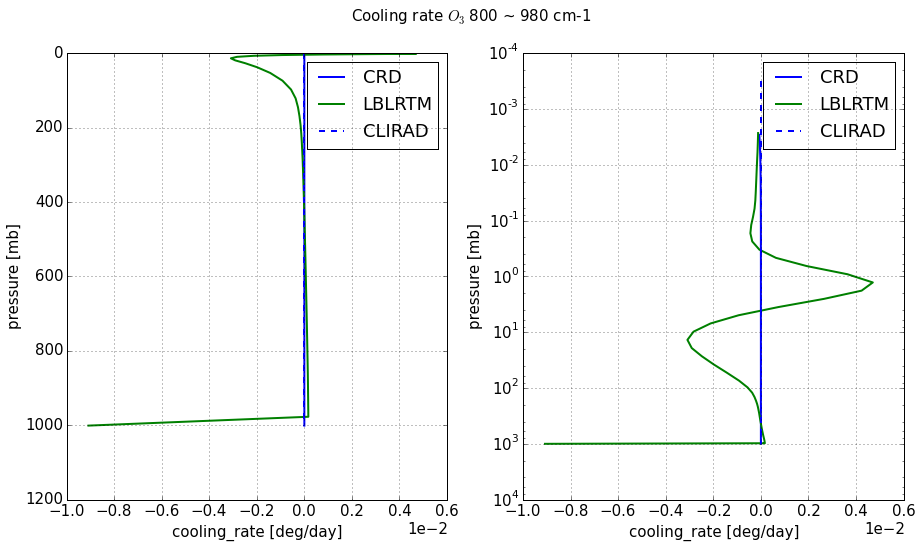

---------------------------------------------------------------------------


Wavenumber band: 5, 980 ~ 1100 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -23.076111   0.000000 -23.076111      0.000000
30   299.800000 -29.412917   2.063562 -27.349356     -0.059957
0   1013.000000 -31.354231   4.378188 -26.976043      0.026399

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -22.883789   0.000000 -22.883789      0.000000
30   299.8000 -29.405425   2.076119 -27.329306     -0.061748
0   1013.0000 -31.337711   4.357831 -26.979879      0.021684

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -22.01741  4.842877e-07 -22.017410     -0.139192
30   299.800000 -29.28325  2.313905e+00 -26.969345     -0.058855
0   1013.000000 -31.34392  4.914667e+00 -26.429253      0.029646

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.192323   0.000000 -0.

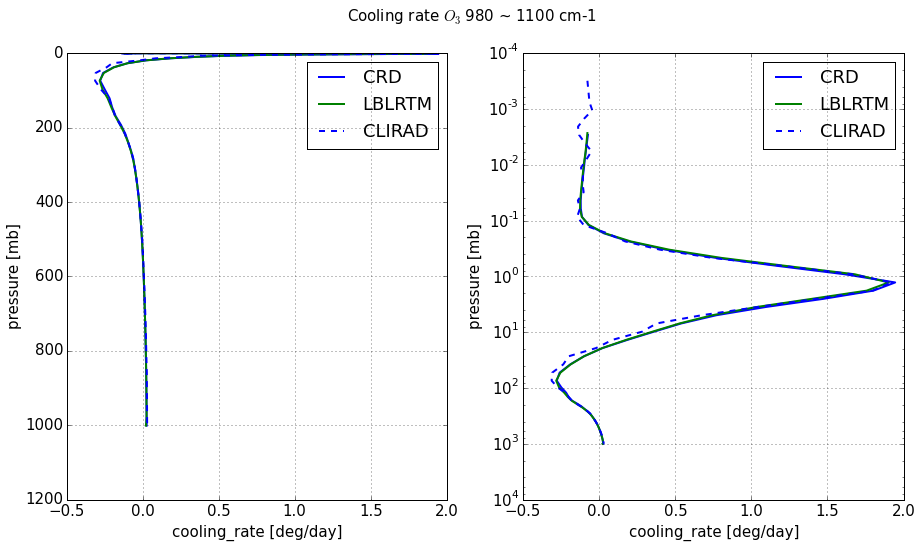

---------------------------------------------------------------------------


Wavenumber band: 6, 1100 ~ 1215 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -23.269652  0.000000e+00 -23.269652  0.000000e+00
30   299.800000 -23.269652  4.643548e-08 -23.269652 -8.180951e-10
0   1013.000000 -23.269652  1.389566e-07 -23.269652  1.618239e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -22.796020   0.000000 -22.796020      0.000000
30   299.8000 -23.215059   0.100448 -23.114611     -0.001012
0   1013.0000 -23.254791   0.142869 -23.111922     -0.002761

CLIRAD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -23.27341          0 -23.27341            -0
30   299.800000 -23.27341          0 -23.27341            -0
0   1013.000000 -23.27341          0 -23.27341            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.473631   0.000000 -0.473

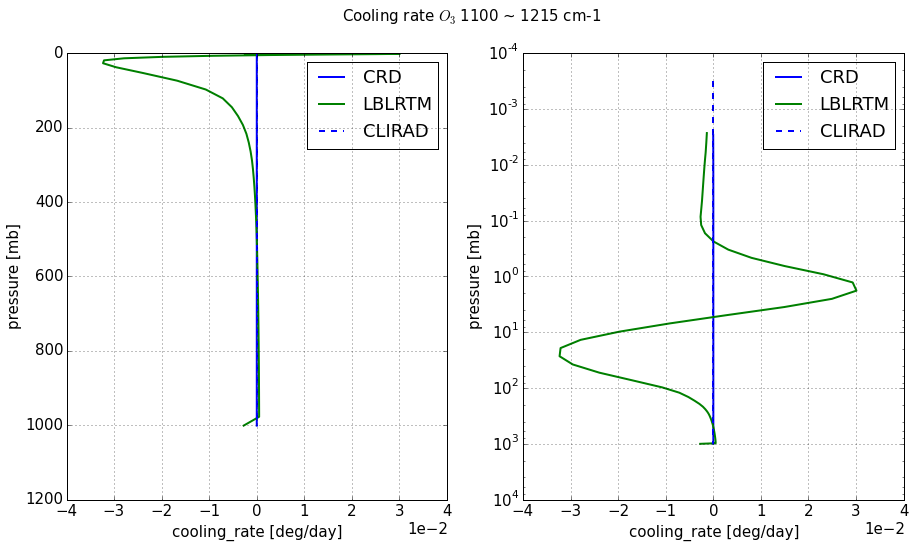

---------------------------------------------------------------------------


Wavenumber band: 7, 1215 ~ 1380 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -23.755165  0.000000e+00 -23.755165  0.000000e+00
30   299.800000 -23.755165  4.129745e-08 -23.755165 -9.604811e-10
0   1013.000000 -23.755165  1.320426e-07 -23.755165  1.648939e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -23.726660   0.000000 -23.726660      0.000000
30   299.8000 -23.727695   0.000254 -23.727442     -0.000003
0   1013.0000 -23.736876   0.000438 -23.736439     -0.003216

CLIRAD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -23.74062          0 -23.74062            -0
30   299.800000 -23.74062          0 -23.74062            -0
0   1013.000000 -23.74062          0 -23.74062            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.028504   0.000000 -0.028

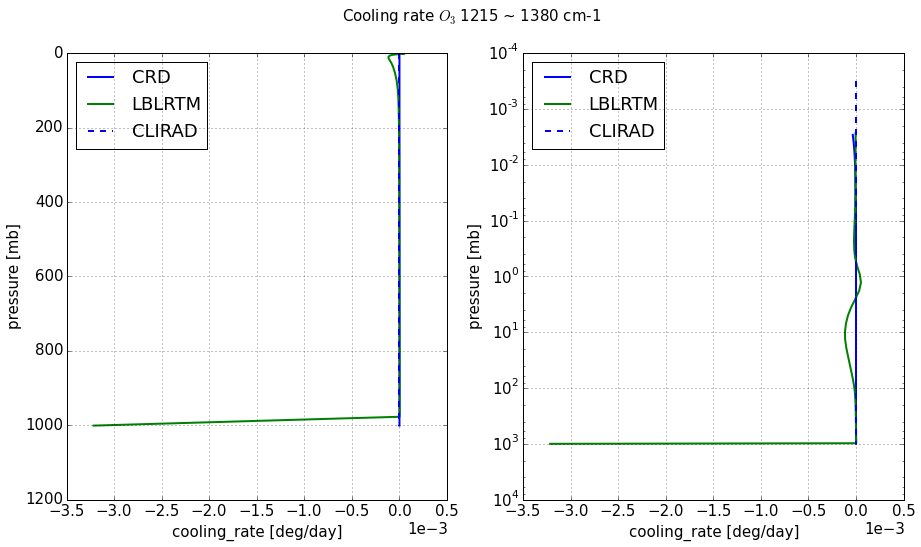

---------------------------------------------------------------------------


Wavenumber band: 8, 1380 ~ 1900 cm-1

CRD
       pressure    flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -30.729595  0.000000e+00 -30.729595  0.000000e+00
30   299.800000 -30.729595  4.106866e-08 -30.729595 -1.499367e-09
0   1013.000000 -30.729595  1.496447e-07 -30.729595  2.124841e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -30.640443   0.000000 -30.640443      0.000000
30   299.8000 -30.680089   0.003981 -30.676109     -0.000104
0   1013.0000 -30.697533   0.006264 -30.691269     -0.005225

CLIRAD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -30.88047  2.421439e-07 -30.880470            -0
30   299.800000 -30.88047  1.966953e-06 -30.880468            -0
0   1013.000000 -30.88047  1.966953e-06 -30.880468            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.089152  

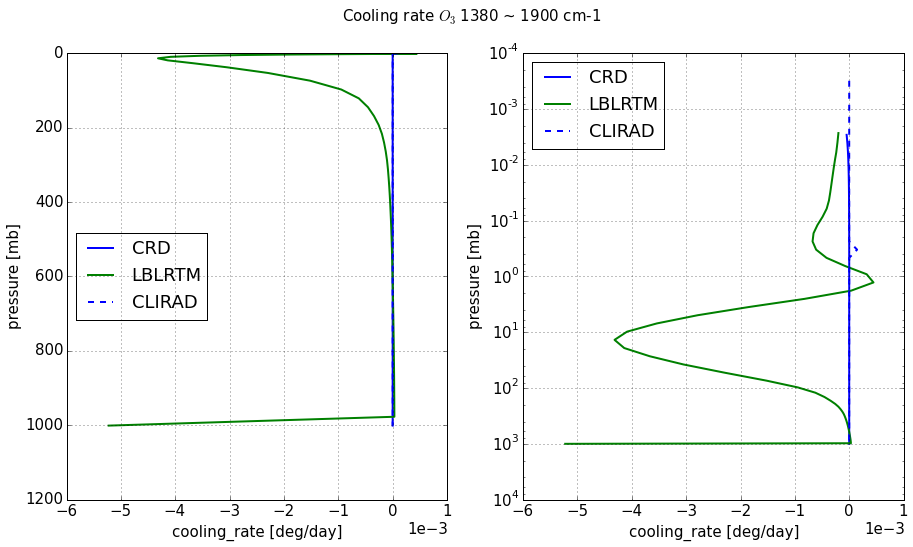

---------------------------------------------------------------------------


Wavenumber band: 9, 1900 ~ 3000 cm-1

CRD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -6.625445  0.000000e+00 -6.625445  0.000000e+00
30   299.800000 -6.625445  5.418739e-09 -6.625445 -3.942476e-10
0   1013.000000 -6.625445  2.564721e-08 -6.625445  4.544859e-10

LBLRTM
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -6.405988   0.000000 -6.405988      0.000000
30   299.8000 -6.536228   0.006685 -6.529543     -0.000591
0   1013.0000 -6.614782   0.016728 -6.598054     -0.022461

CLIRAD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -6.674494 -1.536682e-08 -6.674494            -0
30   299.800000 -6.674494 -2.533197e-07 -6.674494            -0
0   1013.000000 -6.674494 -5.066395e-07 -6.674495            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.219457   0.000000 -0.219457 

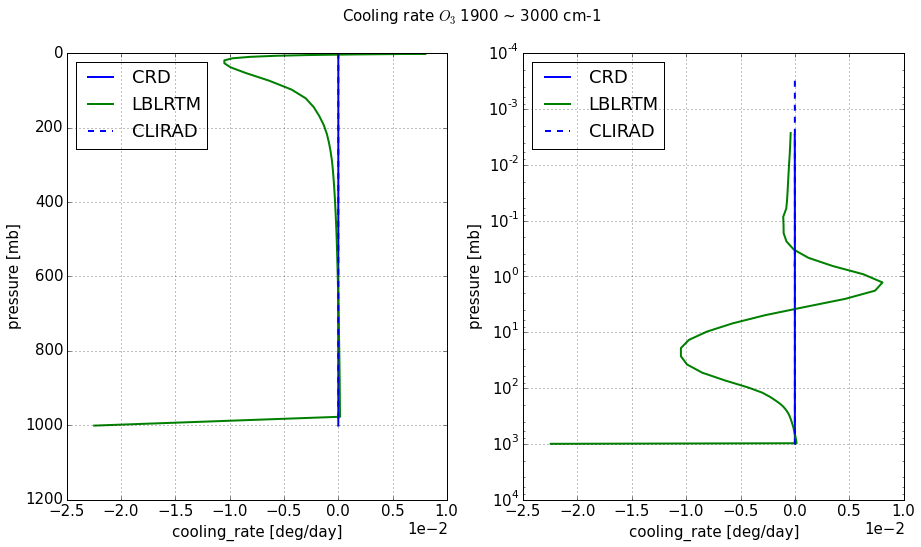

---------------------------------------------------------------------------


Wavenumber band: 10, 540 ~ 620 cm-1

CRD
       pressure   flux_up     flux_down  net_flux  cooling_rate
70     0.002417 -36.23542  0.000000e+00 -36.23542  0.000000e+00
30   299.800000 -36.23542  1.339173e-07 -36.23542 -7.753076e-11
0   1013.000000 -36.23542  3.059209e-07 -36.23542  2.538879e-09

LBLRTM
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -36.212558   0.000000 -36.212558      0.000000
30   299.8000 -36.223754   0.008035 -36.215719     -0.000004
0   1013.0000 -36.231410   0.010693 -36.220717     -0.002380

CLIRAD
       pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.002417       -0          0         0            -0
30   299.800000       -0          0         0            -0
0   1013.000000       -0          0         0            -0

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000017 -0.022862   0.000000 -0.022862      0.00

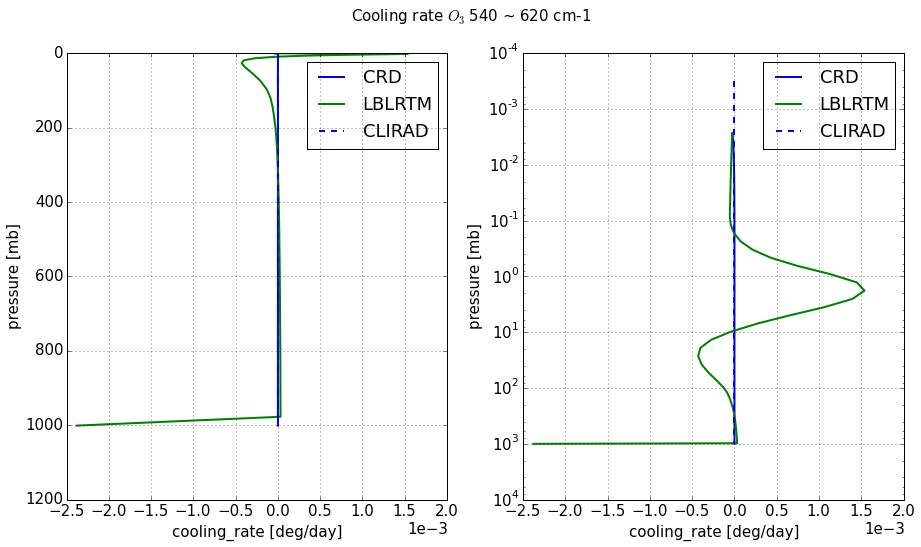

In [13]:
print('Flux tables and cooling rates in CLIRAD spectral bands')
print()
print()

fluxtableNhrplot_by_clirad_bands(pnl_clirad, \
                                ('CRD', 'b', '-', pnl_crd), \
                                ('LBLRTM', 'g', '-', pnl_lblrtm))

In [66]:
display.HTML('''
<script>
show_code = true;
function code_toggle() {
if (show_code) {$('div.input').hide();} else {$('div.input').show();}
show_code = !show_code
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code"></form>
''')